In [1]:
from urllib.request import urlretrieve
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import numpy as np
from keras.datasets import mnist
from keras.layers import Dense, Flatten
from keras.layers import Conv2D, Input
import nengo
import nengo_dl

In [2]:
(train_images, train_labels), (
    test_images,
    test_labels,
) = tf.keras.datasets.mnist.load_data()

# flatten images and add time dimension
train_images = train_images.reshape((train_images.shape[0], 1, -1))
train_labels = train_labels.reshape((train_labels.shape[0], 1, -1))
test_images = test_images.reshape((test_images.shape[0], 1, -1))
test_labels = test_labels.reshape((test_labels.shape[0], 1, -1))

In [3]:
# input
inp = tf.keras.Input(shape=(28, 28, 1))

# convolutional layers
conv0 = tf.keras.layers.Conv2D(
    filters=32,
    kernel_size=3,
    activation=tf.nn.relu,
)(inp)

conv1 = tf.keras.layers.Conv2D(
    filters=64,
    kernel_size=3,
    strides=2,
    activation=tf.nn.relu,
)(conv0)

# fully connected layer
flatten = tf.keras.layers.Flatten()(conv1)
dense = tf.keras.layers.Dense(units=10)(flatten)

model = tf.keras.Model(inputs=inp, outputs=dense)


In [4]:
converter = nengo_dl.Converter(model)

In [5]:
do_training = True
if do_training:
    with nengo_dl.Simulator(converter.net, minibatch_size=200) as sim:
        # run training
        sim.compile(
            optimizer=tf.optimizers.RMSprop(0.001),
            loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=[tf.metrics.sparse_categorical_accuracy],
        )
        sim.fit(
            {converter.inputs[inp]: train_images},
            {converter.outputs[dense]: train_labels},
            validation_data=(
                {converter.inputs[inp]: test_images},
                {converter.outputs[dense]: test_labels},
            ),
            epochs=2,
        )

        # save the parameters to file
        sim.save_params("./keras_to_snn_params")
else:
    # download pretrained weights
    urlretrieve(
        "https://drive.google.com/uc?export=download&"
        "id=1lBkR968AQo__t8sMMeDYGTQpBJZIs2_T",
        "keras_to_snn_params.npz",
    )
    print("Loaded pretrained weights")

Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
Construction finished in 0:00:00                                               
Epoch 1/2
300/300 [==============================] - 11s 36ms/step - loss: 0.6530 - probe_loss: 0.6530 - probe_sparse_categorical_accuracy: 0.9320 - val_loss: 0.0754 - val_probe_loss: 0.0754 - val_probe_sparse_categorical_accuracy: 0.9758

In [6]:
def run_network(
    activation,
    params_file="keras_to_snn_params",
    n_steps=30,
    scale_firing_rates=1,
    synapse=None,
    n_test=400,
):
    # convert the keras model to a nengo network
    nengo_converter = nengo_dl.Converter(
        model,
        swap_activations={tf.nn.relu: activation},
        scale_firing_rates=scale_firing_rates,
        synapse=synapse,
    )

    # get input/output objects
    nengo_input = nengo_converter.inputs[inp]
    nengo_output = nengo_converter.outputs[dense]

    # add a probe to the first convolutional layer to record activity.
    # we'll only record from a subset of neurons, to save memory.
    sample_neurons = np.linspace(
        0,
        np.prod(conv0.shape[1:]),
        1000,
        endpoint=False,
        dtype=np.int32,
    )
    with nengo_converter.net:
        conv0_probe = nengo.Probe(nengo_converter.layers[conv0][sample_neurons])

    # repeat inputs for some number of timesteps
    tiled_test_images = np.tile(test_images[:n_test], (1, n_steps, 1))

    # set some options to speed up simulation
    with nengo_converter.net:
        nengo_dl.configure_settings(stateful=False)

    # build network, load in trained weights, run inference on test images
    with nengo_dl.Simulator(
        nengo_converter.net, minibatch_size=10, progress_bar=False
    ) as nengo_sim:
        nengo_sim.load_params(params_file)
        data = nengo_sim.predict({nengo_input: tiled_test_images})

    # compute accuracy on test data, using output of network on
    # last timestep
    predictions = np.argmax(data[nengo_output][:, -1], axis=-1)
    accuracy = (predictions == test_labels[:n_test, 0, 0]).mean()
    print("Test accuracy: %.2f%%" % (100 * accuracy))

    # plot the results
    for ii in range(4):
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 3, 1)
        plt.title("Input image")
        plt.imshow(test_images[ii, 0].reshape((28, 28)), cmap="gray")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        scaled_data = data[conv0_probe][ii] * scale_firing_rates
        if isinstance(activation, nengo.SpikingRectifiedLinear):
            scaled_data *= 0.001
            rates = np.sum(scaled_data, axis=0) / (n_steps * nengo_sim.dt)
            plt.ylabel("Number of spikes")
        else:
            rates = scaled_data
            plt.ylabel("Firing rates (Hz)")
        plt.xlabel("Timestep")
        plt.title(
            "Neural activities (conv0 mean=%dHz max=%dHz)" % (rates.mean(), rates.max())
        )
        plt.plot(scaled_data)

        plt.subplot(1, 3, 3)
        plt.title("Output predictions")
        plt.plot(tf.nn.softmax(data[nengo_output][ii]))
        plt.legend([str(j) for j in range(10)], loc="upper left")
        plt.xlabel("Timestep")
        plt.ylabel("Probability")

        plt.tight_layout()

In [7]:
# we'll encourage the neurons to spike at around 250Hz
target_rate = 1000

# convert keras model to nengo network
converter = nengo_dl.Converter(model)

# add probes to the convolutional layers, which
# we'll use to apply the firing rate regularization
with converter.net:
    output_p = converter.outputs[dense]
    conv0_p = nengo.Probe(converter.layers[conv0])
    conv1_p = nengo.Probe(converter.layers[conv1])

with nengo_dl.Simulator(converter.net, minibatch_size=200) as sim:
    # add regularization loss functions to the convolutional layers
    sim.compile(
        optimizer=tf.optimizers.RMSprop(0.001),
        loss={
            output_p: tf.losses.SparseCategoricalCrossentropy(from_logits=True),
            conv0_p: tf.losses.mse,
            conv1_p: tf.losses.mse,
        },
        loss_weights={output_p: 1, conv0_p: 1e-3, conv1_p: 1e-3},
    )

    do_training = True
    if do_training:
        # run training (specifying the target rates for the convolutional layers)
        sim.fit(
            {converter.inputs[inp]: train_images},
            {
                output_p: train_labels,
                conv0_p: np.ones((train_labels.shape[0], 1, conv0_p.size_in))
                * target_rate,
                conv1_p: np.ones((train_labels.shape[0], 1, conv1_p.size_in))
                * target_rate,
            },
            epochs=10,
        )

        # save the parameters to file
        sim.save_params("./keras_to_snn_regularized_params")
    else:
        # download pretrained weights
        urlretrieve(
            "https://drive.google.com/uc?export=download&"
            "id=1xvIIIQjiA4UM9Mg_4rq_ttBH3wIl0lJx",
            "keras_to_snn_regularized_params.npz",
        )
        print("Loaded pretrained weights")

Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
Construction finished in 0:00:00                                               
Epoch 1/10
300/300 [==============================] - 16s 54ms/step - loss: 1891.1060 - probe_loss: 52.1132 - probe_1_loss: 930381.3750 - probe_2_loss: 908611.4375

Test accuracy: 90.50%


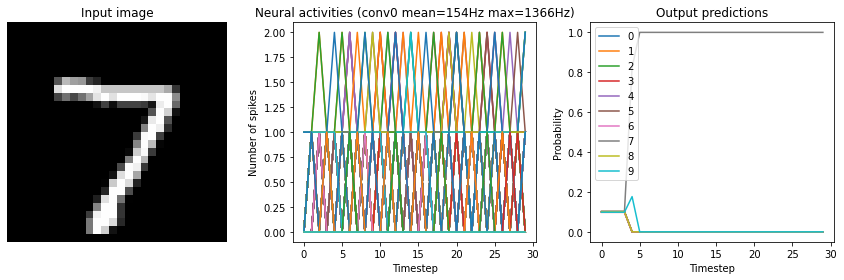

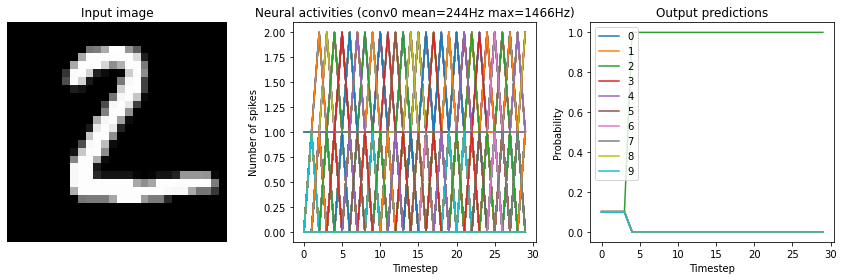

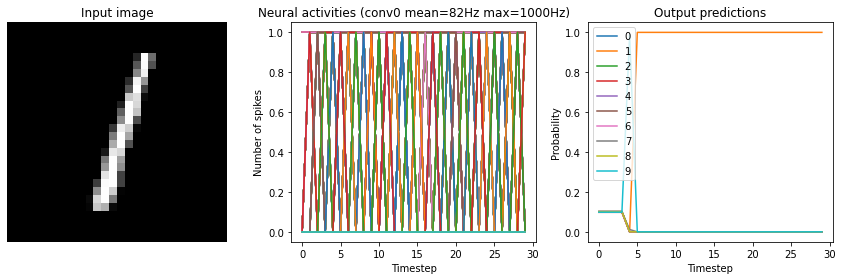

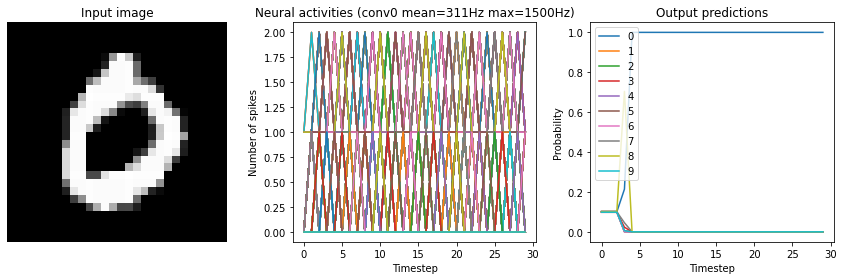

In [8]:
run_network(
    activation=nengo.SpikingRectifiedLinear(),
    params_file="keras_to_snn_regularized_params",
    synapse=0.01,
)